In [18]:
import sys
# sys.path.insert(0, '/home/emmanuel/code/kernellib')
sys.path.insert(0, '/home/emmanuel/code/py_esdc')
sys.path.insert(0, '/home/emmanuel/projects/2019_sakame/')

# from showprogress import showprogress
import xarray as xr
import numpy as np
import pandas as pd
import h5py

# Data
from src.data.regression import load_esdc

# Feature Extraction/Transformations
from esdc.transform import DensityCubes
from src.features.classification import get_common_elements

# GP Models
from src.models.regression import gpr_naive
from src.models.derivatives import GPRDerivative
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from src.models.utils import predict_batches

# Visualization
from esdc.visualize import plot_xarray_on_map, plot_map
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
xr.set_options(display_style='html')
plt.style.use('ggplot')

# notebook extensions
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

For this experiment, we are going to be looking at the region of Europe for the duration of the year 2010. The variables in question are Gross Primary Productivity (GPP) and Land Surface Temperature (LST)

In [2]:
cube_europe = load_esdc()
cube_europe

<xarray.Dataset>
Dimensions:                     (lat: 144, lon: 312, time: 46)
Coordinates:
  * time                        (time) datetime64[ns] 2010-01-05 ... 2010-12-31
  * lon                         (lon) float32 -17.875 -17.625 ... 59.625 59.875
  * lat                         (lat) float32 71.375 71.125 ... 35.875 35.625
Data variables:
    gross_primary_productivity  (time, lat, lon) float32 nan nan ... 0.34496197
    land_surface_temperature    (time, lat, lon) float32 nan nan ... 287.3448
Attributes:
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x720x1440
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    creator_email:             info@earthsystemdatalab.net
    creator_name:              Brockmann Consult GmbH 
    creator_url:               www.earthsystemdatalab.net
    date_created:              17.12.2018
    date_issued:               19.12.2018
    date_modified:             17.12.2018
    geospatial_lat_max:        89.75
    geospatial_lat_min:        -89.75
    geospatial_lon_max:        179.75
    geospatial_lon_min:        -179.75
    geospatial_resolution:     1/4deg
    history:                   - processing with esdl cube v0.1  (https://git...
    id:                        v2.0.0
    institution:               Brockmann Consult GmbH 
    keywords:                  Earth Science, Geophysical Variables
    license:                   Please refer to individual variables
    naming_authority:          Earth System Data Lab team
    processing_level:          Level 4
    project:                   ESA Earth System Data Lab 
    publisher_email:           info@earthsystemdatalab.net
    publisher_name:            Brockmann Consult GmbH & Max Planck Institute ...
    publisher_url:             www.brockmann-consult.de
    standard_name_vocabulary:  CF-1.7
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P37Y
    time_coverage_end:         30.12.2016
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1980
    title:                     Earth System Data Cube

### Visualize

/home/emmanuel/.conda/envs/sakame/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


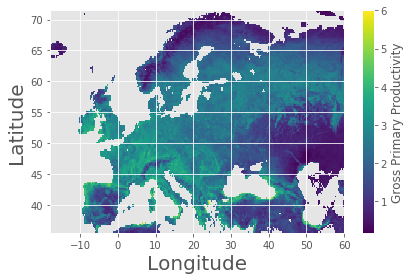

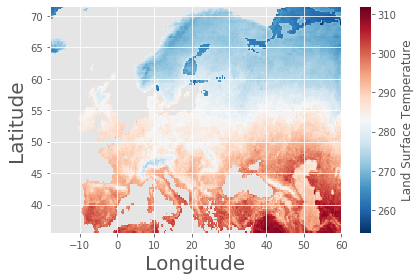

In [6]:
fig, ax = plot_map(
    cube_europe.gross_primary_productivity.mean(dim='time'),
    cmap="viridis",
    cbar_kwargs = {'label':'Gross Primary Productivity'}
)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
plt.tight_layout()
plt.show()

fig, ax = plot_map(
    cube_europe.land_surface_temperature.mean(dim='time'),
    cmap="RdBu_r",
    cbar_kwargs = {'label':'Land Surface Temperature'}
)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
plt.tight_layout()
plt.show()

## Extract MiniCubes

In [7]:
DensityCubes?

Init signature:
DensityCubes(
    spatial_window=3,
    time_window=3,
    spatial_step=1,
    time_step=1,
    temporal_point='end',
)
Docstring:     
A class that extracts subsets of cubes from the xarray datacube. This cube is designed
to work with xr.DataArray structures with 2 spatial dimensions and 1 temporal (e.g. 
lat-lon-time). This is useful for density estimation and feature inclusion when we want to have 
more features/dimensions that stem from the spatial and temporal dimensions. Uses 
numpy strides to reduce the amount of memory overhead and is relatively quick.

Parameters
----------
spatial_window : int, default=3
    The number of dimensions for the spatial windows (x2) for the cube.
    Note: if the time window is even then we take the ceil 

time_window : int, default = 3
    The number of dimensions for the temporal window (x1) for the cube.

spatial_step : int, default = 1
    The amount of steps in the spatial direction for the spatial windows.

time_step : int, d

#### Save MiniCubes

In [90]:
spatial_window = 3
time_window = 1
# save_name = 'sakame'
minicuber = DensityCubes(spatial_window=spatial_window, time_window=time_window)

# get density Cubes
minicube_gpp_df = minicuber.get_minicubes(cube_europe.gross_primary_productivity)
minicube_lst_df = minicuber.get_minicubes(cube_europe.land_surface_temperature)

### Get Common Elements 

We need to reduce the dataframes such that they have the same elements. 

In [91]:
minicube_gpp_df, minicube_lst_df = get_common_elements(
    minicube_gpp_df, minicube_lst_df
)

In [92]:
minicube_gpp_df.shape, minicube_lst_df.shape

((813164, 9), (813164, 9))

## Train-Test Split

Since we are doing the most naive thing, we don't need to do too much preprocessing. We simply need to split the data into training and testing. I will be using 3_000 datapoints for training.

In [93]:
minicube_gpp_df.head()

var_x0    var_x1    var_x2    var_x3    var_x4  \
time       lat    lon                                                       
2010-12-23 51.375 9.875  0.091307  0.107548  0.134524  0.149985  0.117542   
           51.125 9.125  0.022483  0.183974  0.147064  0.011120  0.097748   
                  9.375  0.183974  0.147064  0.149985  0.097748  0.216434   
                  9.625  0.147064  0.149985  0.117542  0.216434  0.117527   
           51.875 9.125  0.065327  0.058475  0.075531  0.058524  0.053103   

                           var_x5    var_x6    var_x7    var_x8  
time       lat    lon                                            
2010-12-23 51.375 9.875  0.171524  0.117527  0.111816  0.119083  
           51.125 9.125  0.216434  0.128752  0.052081  0.130526  
                  9.375  0.117527  0.052081  0.130526  0.144977  
                  9.625  0.111816  0.130526  0.144977  0.131834  
           51.875 9.125  0.053526  0.076429  0.047396  0.098002

In [168]:
# training test
X = minicube_gpp_df.iloc[:, 1:]
y = minicube_gpp_df.iloc[:, 0]


Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, train_size=3_000, random_state=123
)

## Train GPR Model

In [170]:
gpr_model = gpr_naive(
    Xtrain, 
    ytrain[:, None], 
    n_restarts_optimizer=0, 
    normalize_y=True, 
    random_state=123
)

## Predictions w. GP Model

We will have to predict in batches because it is a lot of data

In [242]:
from src.models.regression import predict_batches

In [216]:
# initialize GPR Derivative Model
gpr_der_model = GPRDerivative(gpr_model)

predictions, derivatives = predict_batches(
    gpr_model, gpr_der_model, Xtest.values, ytest.values, batch_size=10_000
)

In [228]:
predictions.shape, ytest.values.shape, acc.shape

((810164, 1), (810164,), (810164, 1))

In [229]:
# calculate relevant statistics
acc = np.abs(ytest.values[:, None], predictions)
r2 = r2_score(ytest.values, predictions)
sensitivities = np.mean(np.abs(derivatives), axis=1) / (spatial_window ** 2 - 1)


In [233]:
acc.shape

(810164, 1)

In [234]:
# Predictions
ypred_ = pd.Series(predictions.squeeze(), index=ytest.index).to_frame()
ypred_.columns = ['Predictions']

# Mean Absolute Errors
yacc_ = pd.Series(acc.squeeze(), index=ytest.index).to_frame()
yacc_.columns = ['Error']

# Labels
ytest_ = ytest.to_frame()
ytest_.columns = ['Labels']

# Derivatives
ysens_ = pd.DataFrame(data=sensitivities.squeeze(), index=ytest.index)
ysens_.columns = ['Sensitivity']



In [235]:
# concatenate
y_ = pd.concat([ytest_, yacc_, ypred_, ysens_], axis=1)

# convert to xarray
xr_preds = y_.to_xarray()
xr_preds

<xarray.Dataset>
Dimensions:      (lat: 142, lon: 294, time: 46)
Coordinates:
  * time         (time) datetime64[ns] 2010-01-05 2010-01-13 ... 2010-12-31
  * lat          (lat) float64 35.88 36.12 36.38 36.62 ... 70.62 70.88 71.12
  * lon          (lon) float64 -17.62 -17.38 -17.12 -16.88 ... 59.12 59.38 59.62
Data variables:
    Labels       (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    Error        (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    Predictions  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    Sensitivity  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan

## Plots

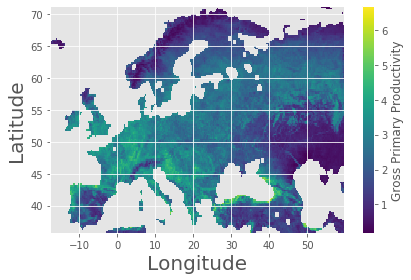

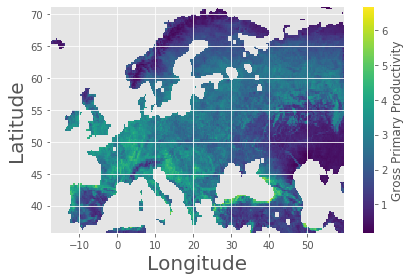

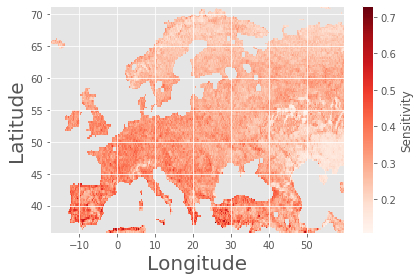

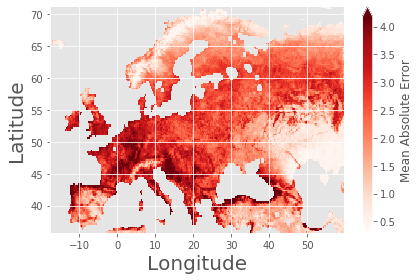

In [243]:
fig, ax = plot_map(
    xr_preds.Labels.mean(dim='time'),
    cmap="viridis",
    cbar_kwargs = {'label':'Gross Primary Productivity'}
)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
plt.tight_layout()
plt.show()

fig, ax = plot_map(
    xr_preds.Predictions.mean(dim='time'),
    cmap="viridis",
    cbar_kwargs = {'label':'Gross Primary Productivity'}
)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
plt.tight_layout()
plt.show()

fig, ax = plot_map(
    xr_preds.Sensitivity.mean(dim='time'),
    cmap="Reds",
    cbar_kwargs = {'label':'Sensitivity'}
)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
plt.tight_layout()
plt.show()

fig, ax = plot_map(
    xr_preds.Error.mean(dim='time'),
    cmap="Reds",
    robust=True,
    cbar_kwargs = {'label':'Mean Absolute Error'}
)
ax.set_xlabel('Longitude', fontsize=20)
ax.set_ylabel('Latitude', fontsize=20)
plt.tight_layout()
plt.show()